In [ ]:
# Big Data Scaling Final Project
# Sunspot Prediction

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.master("local[4]").appName("sunspots").getOrCreate()

In [4]:
!pwd

/


In [3]:
# Read data
df = spark.read.csv("hdfs://cluster-bigdata1-m/user/dataproc/sunspots.csv", header=True, inferSchema=True)
df.show()

+---+-------------------+---------------------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number|
+---+-------------------+---------------------------------+
|  0|1749-01-31 00:00:00|                             96.7|
|  1|1749-02-28 00:00:00|                            104.3|
|  2|1749-03-31 00:00:00|                            116.7|
|  3|1749-04-30 00:00:00|                             92.8|
|  4|1749-05-31 00:00:00|                            141.7|
|  5|1749-06-30 00:00:00|                            139.2|
|  6|1749-07-31 00:00:00|                            158.0|
|  7|1749-08-31 00:00:00|                            110.5|
|  8|1749-09-30 00:00:00|                            126.5|
|  9|1749-10-31 00:00:00|                            125.8|
| 10|1749-11-30 00:00:00|                            264.3|
| 11|1749-12-31 00:00:00|                            142.0|
| 12|1750-01-31 00:00:00|                            122.2|
| 13|1750-02-28 00:00:00|               

In [13]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Monthly Mean Total Sunspot Number: double (nullable = true)



## EDA

In [15]:
# How many sunspot counts?
df.count()

3265

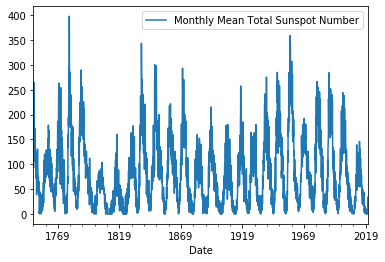

In [6]:
# Plot data
import pandas as pd
df.toPandas().plot.line(x="Date", y="Monthly Mean Total Sunspot Number")

In [4]:
# Feature engineering
# change timestamps to date, month, and year

from pyspark.sql.functions import *
df = df.withColumn("date_type", to_date("Date")).withColumn("month", month("date")).withColumn("year", year("date"))

In [5]:
# Feature engineering
# add dummy column for window function
df = df.withColumn("dummy", col("_c0") * 0)
df.show()

+---+-------------------+---------------------------------+----------+-----+----+-----+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|
+---+-------------------+---------------------------------+----------+-----+----+-----+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|
|  3|1749-04-30 00:00:00|                             92.8|1749-04-30|    4|1749|    0|
|  4|1749-05-31 00:00:00|                            141.7|1749-05-31|    5|1749|    0|
|  5|1749-06-30 00:00:00|                            139.2|1749-06-30|    6|1749|    0|
|  6|1749-07-31 00:00:00|                            158.0|1749-07-31|    7|1749|    0|
|  7|1749-08-31 00:00:00|                            110.5|1749-08-31|    8|1749|    0|
|  8|1749-09-30 00:00:00|       

In [9]:
# Feature Engineering
# include lag for 1, 5, and 11 years
window = Window.partitionBy("dummy").orderBy("_c0")

df_lag = df.withColumn("lag_1_year", lag("Monthly Mean Total Sunspot Number", 12).over(window)).withColumn("lag_5_year", lag("Monthly Mean Total Sunspot Number", 60).over(window)).withColumn("lag_11_year", lag("Monthly Mean Total Sunspot Number", 121).over(window))
df_lag.show(130)

+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      null|      null|       null|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      null|      null|       null|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|      null|      null|       null|
|  3|1749-04-30 00:00:00|                             92.8|1749-04-30|    4|1749|    0|      null|      null|       null|
|  4|1749-05-31 00:00:00|                            141.7|1749-05-31|    5|1749|    0|      null|      null|       null|
|  5|1749-06-30 00:00:00

In [10]:
# Feature Engineering
# Add moving average
window_avg_1 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-12, 0)
window_avg_5 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-60, 0)
window_avg_11 = Window.partitionBy("dummy").orderBy("_c0").rangeBetween(-121, 0)

df_final = df_lag.withColumn("avg_1_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_1)).withColumn("avg_5_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_5)).withColumn("avg_11_year", avg("Monthly Mean Total Sunspot Number").over(window_avg_11))
df_final.select("lag_1_year", "lag_5_year", "lag_11_year", "avg_1_year", "avg_5_year","avg_11_year").show()

+----------+----------+-----------+------------------+------------------+------------------+
|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+----------+----------+-----------+------------------+------------------+------------------+
|      null|      null|       null|              96.7|              96.7|              96.7|
|      null|      null|       null|             100.5|             100.5|             100.5|
|      null|      null|       null|105.89999999999999|105.89999999999999|105.89999999999999|
|      null|      null|       null|           102.625|           102.625|           102.625|
|      null|      null|       null|110.44000000000001|110.44000000000001|110.44000000000001|
|      null|      null|       null|115.23333333333335|115.23333333333335|115.23333333333335|
|      null|      null|       null|121.34285714285716|121.34285714285716|121.34285714285716|
|      null|      null|       null|119.98750000000001|119.987500000000

In [44]:
# See yearly, monthly averages
yearly_avg = df_final.groupBy("year").agg(mean(col('Monthly Mean Total Sunspot Number')).alias("Yearly Avg"))
yearly_avg.show()

+----+------------------+
|year|        Yearly Avg|
+----+------------------+
|1829|111.60833333333333|
|1959|224.79999999999995|
|1896|              69.7|
|1990|191.39166666666665|
|1903| 40.65833333333333|
|1884|105.84166666666665|
|1975|22.408333333333335|
|1977| 39.34166666666667|
|1766|19.016666666666666|
|1787|220.04999999999998|
|1888|            11.225|
|1808|13.566666666666668|
|1863| 83.55833333333335|
|1924|27.858333333333334|
|1823| 2.983333333333333|
|2003| 99.03333333333335|
|1869|123.44166666666666|
|2007|12.633333333333335|
|1892|121.60833333333333|
|2018| 7.008333333333334|
+----+------------------+
only showing top 20 rows



In [45]:
monthly_avg = df_final.groupBy("month").agg(mean(col('Monthly Mean Total Sunspot Number')).alias("Monthly Avg"))
monthly_avg.show()

+-----+-----------------+
|month|      Monthly Avg|
+-----+-----------------+
|   12|82.00735294117646|
|    1|78.33186813186809|
|    6|82.44044117647056|
|    3|80.20551470588234|
|    5|83.13566176470587|
|    9|82.86323529411766|
|    4|81.16139705882357|
|    8|83.41948529411765|
|    7|82.32352941176475|
|   10|82.75698529411768|
|   11| 81.0871323529412|
|    2|81.62536764705885|
+-----+-----------------+



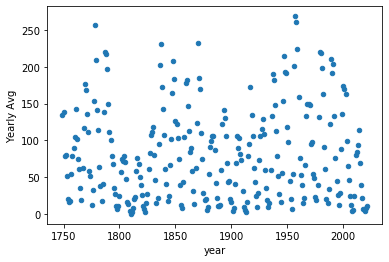

In [49]:
# Plot year/month avgs
yearly_avg.toPandas().plot.scatter(x="year", y="Yearly Avg")

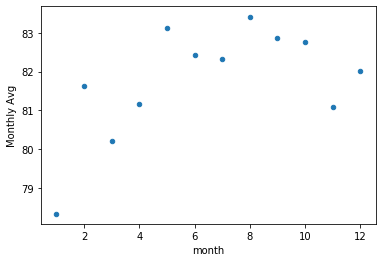

In [50]:
monthly_avg.toPandas().plot.scatter(x="month", y="Monthly Avg")

In [58]:
# There seem to be peaks just after 1750, 1850, 1950. Let's check those out
yearly_avg.orderBy(desc("Yearly Avg")).show()

+----+------------------+
|year|        Yearly Avg|
+----+------------------+
|1957| 268.8416666666667|
|1958|             261.4|
|1778|257.28333333333336|
|1870|231.78333333333333|
|1837|230.49166666666665|
|1959|224.79999999999995|
|1787|220.04999999999998|
|1979|219.85833333333335|
|1980|218.97500000000002|
|1788| 218.1666666666667|
|1947|           214.525|
|1989|211.23333333333332|
|1779|209.88333333333333|
|1848|207.86666666666667|
|1991|203.40833333333333|
|1836|202.43333333333337|
|1956|            200.65|
|1981|198.78333333333333|
|1789| 196.8416666666667|
|1948|192.84166666666673|
+----+------------------+
only showing top 20 rows



In [106]:
## 11 year cycles?
start_year = 1749
gap = 11
cycle_1 = df_final.filter((col("year") >= start_year) & (col("year") < start_year + gap))

In [107]:
gap = 11
start_year = start_year + gap
cycle_2 = df_final.filter((col("year") >= start_year) & (col("year") < start_year + gap))

In [108]:
gap = 11
start_year = start_year + (gap)
cycle_3 = df_final.filter((col("year") >= start_year) & (col("year") < start_year + gap))


In [109]:
gap = 11
start_year = start_year + (gap)
cycle_4 = df_final.filter((col("year") >= start_year) & (col("year") < start_year + gap))

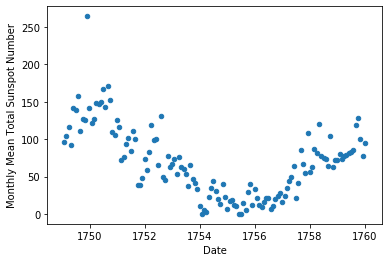

In [110]:
# Plot the cycles
cycle_1.toPandas().plot.scatter(x="Date", y="Monthly Mean Total Sunspot Number")

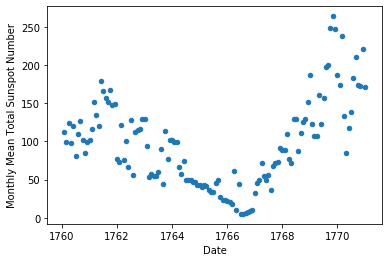

In [111]:
# Plot the cycles
cycle_2.toPandas().plot.scatter(x="Date", y="Monthly Mean Total Sunspot Number")

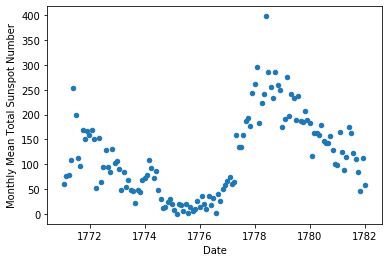

In [112]:
# Plot the cycles
cycle_3.toPandas().plot.scatter(x="Date", y="Monthly Mean Total Sunspot Number")

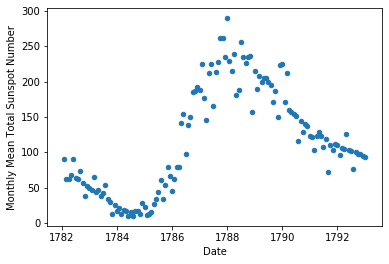

In [113]:
# Plot the cycles
cycle_4.toPandas().plot.scatter(x="Date", y="Monthly Mean Total Sunspot Number")

The pairs of graphs above seem to share similar patterns across 11-year cycles. Let's see if this holds further.

In [117]:
cycles = list()
gap = 11
for i in range(1749,1900, 11):
    cycles.append(df_final.filter((col("year") >= i) & (col("year") < i + gap)))

Text(0.5, 0.98, '11-year cycles of sunspots')

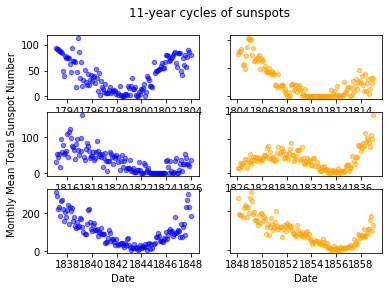

In [132]:
# We'll start at (4,5) since we have already seen the first 4
fig, ax = plt.subplots(nrows=3, ncols =2)
cycles[4].toPandas().plot.scatter(ax = ax[0][0],x="Date", y="Monthly Mean Total Sunspot Number", color = 'blue', alpha = 0.5, subplots=True, sharey=True, ylabel="")
cycles[5].toPandas().plot.scatter(ax=ax[0][1], x="Date", y = "Monthly Mean Total Sunspot Number", color = "orange", alpha = 0.5, subplots=True, sharey=True)

cycles[6].toPandas().plot.scatter(ax = ax[1][0],x="Date", y="Monthly Mean Total Sunspot Number", color = 'blue', alpha = 0.5, subplots=True, sharey=True)
cycles[7].toPandas().plot.scatter(ax=ax[1][1], x="Date", y = "Monthly Mean Total Sunspot Number", color = "orange", alpha = 0.5, subplots=True, sharey=True)

cycles[8].toPandas().plot.scatter(ax = ax[2][0],x="Date", y="Monthly Mean Total Sunspot Number", color = 'blue', alpha = 0.5, subplots=True, sharey=True, ylabel="")
cycles[9].toPandas().plot.scatter(ax=ax[2][1], x="Date", y = "Monthly Mean Total Sunspot Number", color = "orange", alpha = 0.5)


fig.suptitle("11-year cycles of sunspots")

In [11]:
# Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder

feature_cols = ["month", "year", "lag_1_year", "lag_5_year", "lag_11_year", "avg_1_year", "avg_5_year", "avg_11_year"]

month_encoder = OneHotEncoder(inputCol="month", outputCol="MonthVector")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("keep")

In [12]:
# Train/test split
split_num = int(3265 * 0.7)
print("Splitting on", split_num)

# split the data based on time, not randomly
train = df_final.filter(df_final._c0 <=split_num)
test = df_final.filter(df_final._c0 > split_num)

train.show()

Splitting on 2285
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      null|      null|       null|              96.7|              96.7|              96.7|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      null|      null|       null|             100.5|             100.5|             100.5|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|

In [43]:
# Number of training samples
train.count()

2286

In [44]:
# Number of testing samples
test.count()

979

In [13]:
split_num = train.count() * 0.7
valid = train.filter(train._c0 > split_num)
train = train.filter(train._c0 <= split_num)

In [44]:
train.count()

1601

In [45]:
valid.count()

685

## Training the Models

In [14]:
# Create models with no parameter optimization

# Linear regression
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


In [52]:
assembler.transform(df_final)

DataFrame[_c0: int, Date: timestamp, Monthly Mean Total Sunspot Number: double, date_type: date, month: int, year: int, dummy: int, lag_1_year: double, lag_5_year: double, lag_11_year: double, avg_1_year: double, avg_5_year: double, avg_11_year: double, features: vector]

In [15]:
rf = RandomForestRegressor(featuresCol="features", labelCol = "Monthly Mean Total Sunspot Number")
pipeline = Pipeline(stages= [month_encoder, assembler, rf])

rf_model = pipeline.fit(train)

rf_valid = rf_model.transform(valid)

In [56]:
rf_valid.show()

+----+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+---------------+--------------------+------------------+
| _c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|    MonthVector|            features|        prediction|
+----+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+---------------+--------------------+------------------+
|1601|1882-06-30 00:00:00|                             75.4|1882-06-30|    6|1882|    0|     100.8|      23.6|      179.5|102.83076923076922| 43.85245901639344| 57.24016393442625| (12,[6],[1.0])|[6.0,1882.0,100.8...|109.38641092015382|
|1602|1882-07-31 00:00:00|                             7

In [31]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Monthly Mean Total Sunspot Number")
evaluator.evaluate(rf_valid)

26.1529397682043

In [58]:
lr = LinearRegression(featuresCol="features", labelCol = "Monthly Mean Total Sunspot Number")
pipeline = Pipeline(stages= [month_encoder, assembler, lr])

lr_model = pipeline.fit(train)

lr_valid = lr_model.transform(valid)

In [62]:
evaluator.evaluate(lr_valid)

nan

In [60]:
gbt = GBTRegressor(featuresCol="features", labelCol = "Monthly Mean Total Sunspot Number")
pipeline = Pipeline(stages= [month_encoder, assembler, gbt])

gbt_model = pipeline.fit(train)

gbt_valid = gbt_model.transform(valid)
#gbt_valid.show()

In [61]:
evaluator.evaluate(gbt_valid)

26.868302625907575

In [71]:
# Try replacing NULL values
first_sunspot = train.select("Monthly Mean Total Sunspot Number").first()[0]

train = train.fillna(first_sunspot, subset=["lag_1_year", "lag_5_year", "lag_11_year"])
train.show()

+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|_c0|               Date|Monthly Mean Total Sunspot Number| date_type|month|year|dummy|lag_1_year|lag_5_year|lag_11_year|        avg_1_year|        avg_5_year|       avg_11_year|
+---+-------------------+---------------------------------+----------+-----+----+-----+----------+----------+-----------+------------------+------------------+------------------+
|  0|1749-01-31 00:00:00|                             96.7|1749-01-31|    1|1749|    0|      96.7|      96.7|       96.7|              96.7|              96.7|              96.7|
|  1|1749-02-28 00:00:00|                            104.3|1749-02-28|    2|1749|    0|      96.7|      96.7|       96.7|             100.5|             100.5|             100.5|
|  2|1749-03-31 00:00:00|                            116.7|1749-03-31|    3|1749|    0|      96.7|      9

In [101]:
pipeline_rf = Pipeline(stages= [month_encoder, assembler, rf])
rf_model_no_nulls = pipeline_rf.fit(train)
rf_valid_no_nulls = rf_model_no_nulls.transform(valid)
evaluator.evaluate(rf_valid_no_nulls)

24.96154645481983

In [102]:
pipeline_lr = Pipeline(stages= [month_encoder, assembler, lr])
lr_model_no_nulls = pipeline_lr.fit(train)
lr_valid_no_nulls = lr_model_no_nulls.transform(valid)
evaluator.evaluate(lr_valid_no_nulls)

23.45988890724147

In [103]:
pipeline_gbt = Pipeline(stages= [month_encoder, assembler, gbt])
gbt_model_no_nulls = pipeline_gbt.fit(train)
gbt_valid_no_nulls = gbt_model_no_nulls.transform(valid)
evaluator.evaluate(gbt_valid_no_nulls)

26.366124730835633

In [80]:
lr_valid_no_nulls.select("Monthly Mean Total Sunspot Number", "prediction", "date_type").show()

+---------------------------------+------------------+----------+
|Monthly Mean Total Sunspot Number|        prediction| date_type|
+---------------------------------+------------------+----------+
|                             75.4|111.61900305786733|1882-06-30|
|                             75.7|101.20469050350023|1882-07-31|
|                             67.5|  102.640568727611|1882-08-31|
|                             96.1|105.28731267193692|1882-09-30|
|                             98.6|100.50949361380734|1882-10-31|
|                            140.6|108.07868201951455|1882-11-30|
|                             69.7|107.96179185316284|1882-12-31|
|                            101.0|108.11194293120565|1883-01-31|
|                             78.2| 98.04220491583332|1883-02-28|
|                             71.3| 94.47599257004454|1883-03-31|
|                            136.8| 83.70513918370733|1883-04-30|
|                             52.5| 86.39218528164912|1883-05-31|
|         

Text(0.5, 1.0, 'Linear Regression Prediction of Sunspot Number')

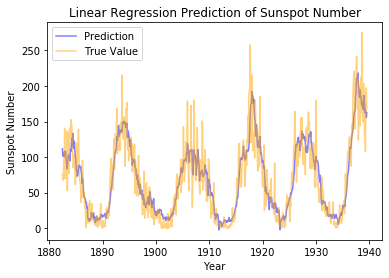

In [100]:
# Plot results from linear regression with fillna
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols =1)
lr_valid_no_nulls.toPandas().plot.line(ax = ax,x="date_type", y="prediction", color = 'blue', alpha = 0.5)
lr_valid_no_nulls.toPandas().plot.line(ax=ax, x="date_type", y = "Monthly Mean Total Sunspot Number", color = "orange", alpha = 0.5)

plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.legend(["Prediction", "True Value"])
plt.title("Linear Regression Prediction of Sunspot Number")

In [104]:
# Test Results
lr_test = lr_model_no_nulls.transform(test)
lr_rmse = evaluator.evaluate(lr_test)
lr_r2 = evaluator.evaluate(lr_test, {evaluator.metricName: "r2"})

print("Linear Regression: ")
print("RMSE: ", lr_rmse)
print("R2: ", lr_r2)
print("-----")

rf_test = rf_model_no_nulls.transform(test)
rf_rmse = evaluator.evaluate(rf_test)
rf_r2 = evaluator.evaluate(rf_test, {evaluator.metricName: "r2"})

print("Random Forest: ")
print("RMSE: ", rf_rmse)
print("R2: ", rf_r2)
print("-----")

gbt_test = gbt_model_no_nulls.transform(test)
gbt_rmse = evaluator.evaluate(gbt_test)
gbt_r2 = evaluator.evaluate(gbt_test, {evaluator.metricName: "r2"})

print("Gradient Boosted Trees: ")
print("RMSE: ", gbt_rmse)
print("R2: ", gbt_r2)

Linear Regression: 
RMSE:  24.171737954641706
R2:  0.8974602176965377
-----
Random Forest: 
RMSE:  30.06956472943945
R2:  0.8413168111634797
-----
Gradient Boosted Trees: 
RMSE:  30.53797236636146
R2:  0.8363345413905323


Text(0.5, 1.0, 'Linear Regression Prediction of Sunspot Number')

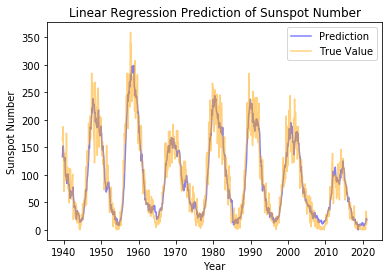

In [105]:
fig, ax = plt.subplots(nrows=1, ncols =1)
lr_test.toPandas().plot.line(ax = ax,x="date_type", y="prediction", color = 'blue', alpha = 0.5)
lr_test.toPandas().plot.line(ax=ax, x="date_type", y = "Monthly Mean Total Sunspot Number", color = "orange", alpha = 0.5)

plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.legend(["Prediction", "True Value"])
plt.title("Linear Regression Prediction of Sunspot Number")

In [26]:
# compare to baseline model - just outputs the average sunspot number
mean_sunspot = train.select(mean(col("Monthly Mean Total Sunspot Number"))).collect()[0][0]
mean_sunspot

80.56127420362272

In [29]:
baseline_preds = test.withColumn("prediction", lit(mean_sunspot))
baseline_preds.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
|80.56127420362272|
+-----------------+
only showing top 20 rows



In [32]:
baseline_rmse = evaluator.evaluate(baseline_preds)
baseline_r2 = evaluator.evaluate(baseline_preds, {evaluator.metricName: "r2"})


print("Gradient Boosted Trees: ")
print("RMSE: ", baseline_rmse)
print("R2: ", baseline_r2)

Gradient Boosted Trees: 
RMSE:  76.5104833518703
R2:  -0.027350241728989477
